In [2]:
import numpy as np
import  matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm

sys.path.insert(0, '../../Modules')
import erqScaling
import erqMedSpec
import os
def sampler(mean1, cov1, mean2, cov2, NG1, NG2):

    X1 = np.random.multivariate_normal(mean1, cov1, NG1)
    X2= np.random.multivariate_normal(mean2, cov2, NG2)

    X_all = np.concatenate((X1,X2), axis=0)
#     np.savetxt(name, X_all)
    return X_all, X1, X2

In [3]:
#  resampling for LOF score of each bin 

from sklearn.neighbors import LocalOutlierFactor as LOF
cc=-1
from matplotlib import cm
nBoot=100
rin =[0, 1,   1.5, 2.5, 4.8, 5.7, 7]
rout=[1, 1.5, 2.5, 4.8, 5.7, 7, 100]
nBin = len(rin)
LOFScoresMedianBins=np.zeros([nBoot,nBin])
opening_angle= np.deg2rad(20)
ERQ_Vector = np.array([1,1,1])/np.sqrt(3)


In [91]:
opening_angle

0.3490658503988659

In [4]:
outG1=[]
outG2=[]
cG2=[]
for k in [70, 100, 150, 200]:
    for s in tqdm(range(nBoot)):

        # Grawing two Gaussian samples
        (data, G1, G2)=sampler([0,0,0], [[1,0,0],[0,1,0], [0,0,1]], [3,3,3], [[1,0,0],[0,1,0], [0,0,1]], 30000, 150)
        C = np.median(data, axis=0)
        cG2.append(np.sum((G2[:,0]>=2.5) & (G2[:,1]>=2.5) & (G2[:,2]>2.5)))
        outG1.append(np.sum((G1[:,0]>=2.5) & (G1[:,1]>=2.5) & (G1[:,2]>2.5)))
        outG2.append(np.sum((G2[:,0]<=2.5) | (G2[:,1]<=2.5) | (G2[:,2]<=2.5)))
        clf= LOF(n_neighbors=k,  n_jobs=-1)
        clf.fit_predict(data)
        LOFScores = -clf.negative_outlier_factor_
        theta = np.zeros([len(data)])
        data_norm = erqMedSpec.uniter(data)
        for i in range(len(data)):
            theta[i] = np.arccos(np.dot(ERQ_Vector, data_norm[i,:]))
        # initializing 
        r = np.sqrt((data[:,0]-C[0])**2 + (data[:,1]-C[1])**2 + (data[:,2]-C[2])**2)
        for b in range(nBin):
            if (b==0):
                mask = (r>=rin[b]) & (r<=rout[b])
            else:
                mask = (r>=rin[b]) & (r<=rout[b]) & (theta<=opening_angle)
            LOFScoresMedianBins[s,b]=np.median(LOFScores[mask])

        np.savetxt('3D-LOFScoresMedianBins-G12-k-%d.dat'%k, LOFScoresMedianBins)
print(np.median(cG2), np.median(outG1), np.median(outG2))


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

49.0 0.0 101.0


4 1.0186601838340452 1.03174269933939
5 1.0475948126749264 1.0637244738490688
6 1.2123412252890966 1.2740130370973604


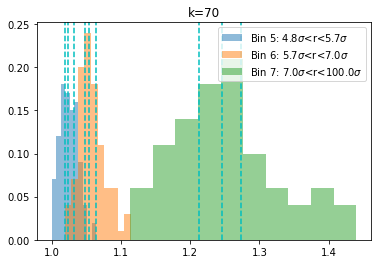

4 1.08178293505822 1.1086156740401505
5 1.0824259955219702 1.1081839668388338
6 1.2021666599420662 1.2771075026334895


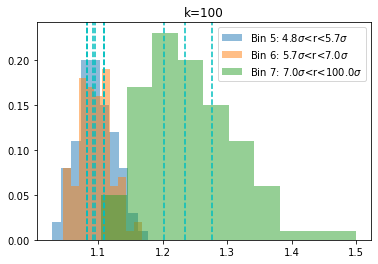

4 1.3214294854702662 1.3649782539577098
5 1.2978739162839161 1.335059230074035
6 1.4213461642392295 1.4794059601015737


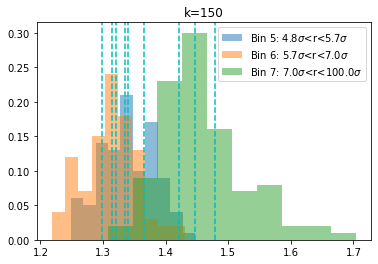

4 1.6120794821443318 1.6421438042430405
5 1.6821930208825138 1.7232818264928245
6 1.8959499203455916 1.9830715773359235


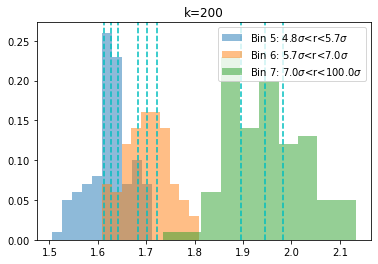

In [5]:
for k in [70, 100, 150, 200]:
# for k in [40, 50, 70, 100, 150, 200]:
    P_all =[]
    med_bin=[]
    width= []
    DistLOFMedBin = np.loadtxt('3D-LOFScoresMedianBins-G12-k-%d.dat'%k)
    l, u, LOFScoreMedian = np.zeros(nBin),  np.zeros(nBin),  np.zeros(nBin)
    for b in range(nBin):
        
        N, bins, patch=plt.hist(DistLOFMedBin[:,b], bins=10)
        med_bin.append((bins[:-1] + bins[1:])/2)
        width.append(bins[1] - bins[0])
        P_all.append(N/np.sum(N))
        plt.clf()
        plt.cla()
    
    for b in range(nBin-3, nBin):
        
        u= np.percentile(DistLOFMedBin[:,b], 68) 
        l= np.percentile(DistLOFMedBin[:,b], 32) 
        m = np.median(DistLOFMedBin[:,b])       
       
        print(b,l,u)
        plt.axvline(x=l, c='c', ls='--')
        plt.axvline(x=u, c='c', ls='--')
        plt.axvline(x=m, c='c', ls='--')
        plt.bar(med_bin[b], P_all[b], width=width[b],  linewidth=0.5, alpha=.5, 
                label=r'Bin %d: %.1f$\sigma$<r<%.1f$\sigma$'%(b+1, rin[b],rout[b]))
    plt.title('k=%d'%k)
    plt.legend()
    plt.savefig('3D_LOF_MOK_PDF-2G-k-%d.png'%k, dpi=200)
    plt.show()


k=70 b=0 l=9.980e-01 m=9.981e-01 u=9.982e-01
k=70 b=1 l=1.002e+00 m=1.003e+00 u=1.004e+00
k=70 b=2 l=1.024e+00 m=1.027e+00 u=1.029e+00
k=70 b=3 l=1.169e+00 m=1.183e+00 u=1.191e+00
k=70 b=4 l=1.019e+00 m=1.023e+00 u=1.032e+00
k=70 b=5 l=1.048e+00 m=1.055e+00 u=1.064e+00
k=70 b=6 l=1.212e+00 m=1.246e+00 u=1.274e+00
k=100 b=0 l=9.969e-01 m=9.971e-01 u=9.972e-01
k=100 b=1 l=1.002e+00 m=1.003e+00 u=1.005e+00
k=100 b=2 l=1.028e+00 m=1.030e+00 u=1.034e+00
k=100 b=3 l=1.211e+00 m=1.225e+00 u=1.241e+00
k=100 b=4 l=1.082e+00 m=1.092e+00 u=1.109e+00
k=100 b=5 l=1.082e+00 m=1.095e+00 u=1.108e+00
k=100 b=6 l=1.202e+00 m=1.235e+00 u=1.277e+00
k=150 b=0 l=9.956e-01 m=9.958e-01 u=9.959e-01
k=150 b=1 l=1.002e+00 m=1.003e+00 u=1.005e+00
k=150 b=2 l=1.036e+00 m=1.038e+00 u=1.041e+00
k=150 b=3 l=1.265e+00 m=1.277e+00 u=1.294e+00
k=150 b=4 l=1.321e+00 m=1.340e+00 u=1.365e+00
k=150 b=5 l=1.298e+00 m=1.314e+00 u=1.335e+00
k=150 b=6 l=1.421e+00 m=1.447e+00 u=1.479e+00
k=200 b=0 l=9.945e-01 m=9.947e-01 u=9.948

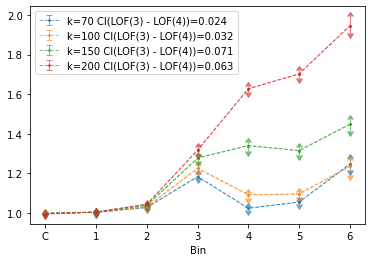

In [4]:
# Plotting 2D Mock LOF error bars 
r1=[0, 0.5,1,1.5,2, 2.5, 3.5,4.5]
r2=[0.5,1,1.5, 2, 2.5, 3.5, 4.5, 7]
from scipy import stats 
P_all =[]
med_bin=[]
width= []
c= ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C8']
cind=-1
for k in [70, 100, 150, 200]:
    DistLOFMedBin = np.loadtxt('3D-LOFScoresMedianBins-G12-k-%d.dat'%k)
    DistDiff = DistLOFMedBin[:,3] - DistLOFMedBin[:,4]
    CI = np.percentile(DistDiff,68) - np.percentile(DistDiff,32)
    l, u, LOFScoreMedian = np.zeros(nBin),  np.zeros(nBin),  np.zeros(nBin)
    for b in range(nBin):
        
        ll= np.percentile(DistLOFMedBin[:,b],32)
        uu= np.percentile(DistLOFMedBin[:,b],68)
        LOFScoreMedian[b] = np.median(DistLOFMedBin[:,b])       
        u[b]=uu - LOFScoreMedian[b]
        l[b]=LOFScoreMedian[b] - ll
        print('k=%d b=%d l=%.3e m=%.3e u=%.3e'%(k, b, ll,LOFScoreMedian[b],uu), )
#     plt.errorbar(['C', '1', '2', '3', '4', '5', '6'], LOFScoreMedian, 
#                  yerr=e,marker='o', lw=2, ls='-',
#              markersize=2, alpha =0.6, label='k=%d'%k, c=c[cind])                       
    cind+=1
    plt.errorbar(np.linspace(0,nBin-1, nBin), LOFScoreMedian, 
                 yerr=l, uplims=False, lolims=True, marker='o', lw=1, ls='--',
             markersize=2, alpha =0.6, 
        label=r'k=%d CI(LOF(3) - LOF(4))=%.3f'%(k, CI), c=c[cind])
    plt.errorbar(['C', '1', '2', '3', '4', '5', '6'], LOFScoreMedian, 
                 yerr=u, uplims=True, lolims=False, marker='o', lw=1, ls='--',
             markersize=2, alpha =0.6, c=c[cind])
plt.xlabel('Bin')
plt.legend()
plt.savefig('LOF_MOK_3D-2G-errorbar.png', dpi=200, bbox_inches='tight')
plt.show()


In [5]:
! cp LOF_MOK_3D-2G-errorbar.png ../../../erqPaper/fig